In [1]:
from config import RANDOM_SEED, IMG_SIZE, PATCH_SIZE, BATCH_SIZE
from input_pipeline import load_data, input_pipeline_test
from scipy.misc import imsave
from sklearn.model_selection import train_test_split
import models
import eval_tools
from tqdm import tqdm
import os
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load model
WEIGHTS_FILE = 'conv2.26-0.9437-0.8241.hdf5'
model = models.convnetv2()
model.load_weights(WEIGHTS_FILE)

In [3]:
# Load data
X_train, Y_train, X_test = load_data()

# Train/validate split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=RANDOM_SEED)

In [4]:
# Evaluate
params = models.get_pipeline_params(model)
val_gen = input_pipeline_test(X_valid, Y_valid, **params)
val_epoch_size = X_valid.shape[0] * (IMG_SIZE // PATCH_SIZE) ** 2 // BATCH_SIZE

dict(zip(model.metrics_names, model.evaluate_generator(val_gen, val_epoch_size)))

{'acc': 0.95296223958333337,
 'f1': 0.69079524651169777,
 'loss': 0.19269806584179605}

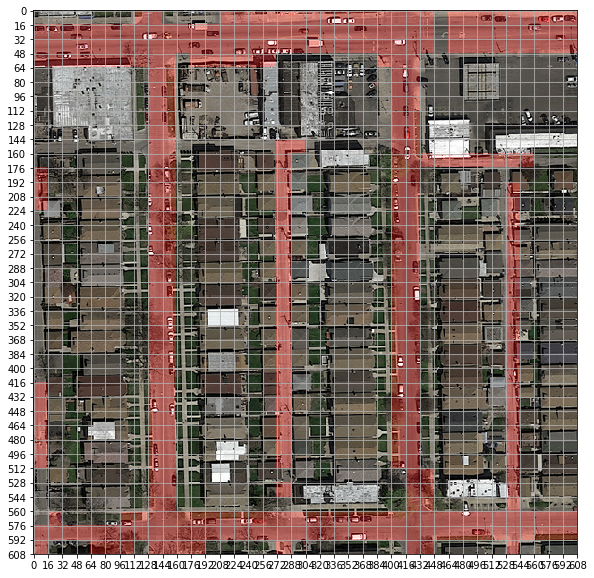

In [4]:
# Show test image
eval_tools.plot_img(eval_tools.predict_img(model, X_test[0]))

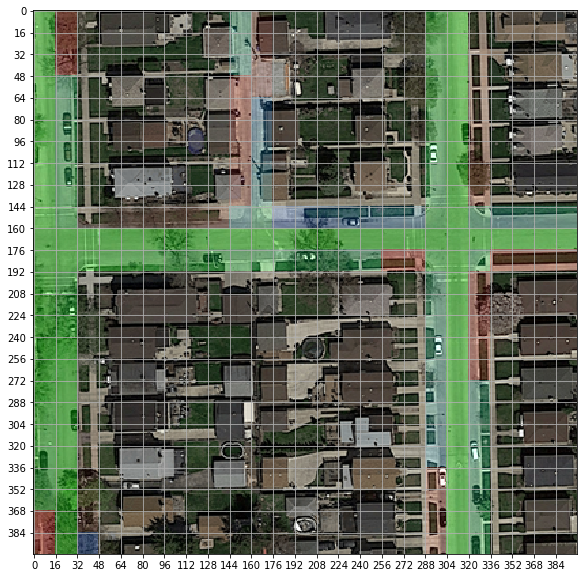

In [5]:
# Show val image
i = 0
eval_tools.plot_img(eval_tools.predict_img(model, X_valid[i], Y_valid[i]))

In [6]:
# Save images of test files
IMG_DIR = WEIGHTS_FILE + '_images'
if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)

for i in tqdm(range(X_test.shape[0])):
    img = eval_tools.predict_img(model, X_test[i])
    filename = IMG_DIR + '/test_%d.png' % i
    imsave(filename, img)

100%|██████████| 50/50 [02:20<00:00,  2.78s/it]


In [ ]:
# Save images of train files
for i in tqdm(range(X_train.shape[0])):
    img = eval_tools.predict_img(model, X_train[i])
    filename = IMG_DIR + '/train_%d.png' % i
    imsave(filename, img)

In [8]:
val_gen = input_pipeline_test(X_valid, Y_valid, **params)
val_patches = X_valid.shape[0] * (IMG_SIZE // PATCH_SIZE) ** 2
val_epoch_size = val_patches // BATCH_SIZE

vx, vy = next(val_gen)
for i in tqdm(range(val_epoch_size)):
    bx, by = next(val_gen)
    vx = np.concatenate((vx, bx))
    vy = np.concatenate((vy, by))
    
vx, vy = vx[:val_patches], vy[:val_patches]
vy = (vy.reshape((vy.shape[0], -1)).mean(axis=1) > .5).astype(int)
py = model.predict(vx, verbose=1)
py = py.reshape((py.shape[0], -1))

100%|██████████| 48/48 [00:13<00:00,  1.96it/s]

  64/6250 [..............................] - ETA: 14s

6250/6250 [==============================] - 10s     

In [14]:
# Find best threshold
ppy = (py.mean(axis=1)>.44).astype(int)
tp, fp, fn, tn = (vy * ppy).sum(), ((1-vy) * ppy).sum(), (vy * (1-ppy)).sum(), ((1-vy)*(1-ppy)).sum()
f1 = 2*tp/(2*tp+fp+fn)
dict(zip(['f1', 'tp', 'fp', 'fn', 'tn'], [f1, tp, fp, fn, tn]))

{'f1': 0.84828711256117451, 'fn': 166, 'fp': 113, 'tn': 5191, 'tp': 780}

In [33]:
(tp+tn)/vy.shape[0]

0.96175999999999995